In [1]:
import pyham
from Bio import SeqIO
import os
import matplotlib.pyplot as plt

# Path to nwk file
nwk_path = "test_data/EstimatedSpeciesTree.nwk"

# The newick tree is extracted as a string
tree_str = pyham.utils.get_newick_string(nwk_path, type="nwk")

# Path to OrthoXML file
#orthoxml_path = "../small_noEvents/OMA.2.3.0/Output/OrthologousGroups.orthoxml" # same error if I use this file
orthoxml_path = "test_data/HierarchicalGroups.orthoxml"

#ham_analysis = pyham.Ham(tree_str, orthoxml_path, use_internal_name=True)
ham_analysis_no_name = pyham.Ham(tree_str, orthoxml_path, use_internal_name=False)

pyham.__version__

'1.1.7'

In [2]:
def locus_to_id(file):
    
    """
    This function extracts loci from a fasta file and store the information as keys in a dictionary 
    and the related protein ID as value.

    Args:
        file (:obj:`str`): path to the file of interest.

    Returns:
        a dictionary mapping the locus (:obj:`str`) with the protein ID (:obj:`str`).
    """
    
    locus_to_id = {}
    for seq_record in SeqIO.parse(file, 'fasta'):
        locus_to_id[seq_record.description.split('locus: ')[-1]] = seq_record.description
        
    return locus_to_id

In [3]:
#locus_to_id("test_data/DB/SE001_aa.fa")

In [4]:
def get_locus(directory):
    
    """
    This function goes through each file of a folder and build a dictionary containing loci 
    as keys and the related protein ID as values. For each entry in the dictionary, the function 
    updates the corresponding :obj:`pyham.abstractgene.Gene` by adding its locus.

    Args:
        directory (:obj:`str`): directory of interest.

    Returns:
        xxx
    """

    path = directory
    for file in os.listdir(path):
        ##print('File:', file)
        path_to_file = path + '/' + file
        locus_dictionary = locus_to_id(path_to_file)
 
        for (loci, gene_id) in locus_dictionary.items():
            gene = ham_analysis_no_name.get_genes_by_external_id(gene_id)
            
            # each gene should only map to 1 other gene, so should always be length 1...
            assert len(gene) == 1, 'gene_id maps to multiple entries'
            gene[0].locus = loci
            #for element in gene:
            #    element.locus = loci
#                print(element.locus)
                
        ham_analysis_no_name.get_extant_genome_by_name('.'.join(file.split('.')[:-1])).locus_assignment = True

In [5]:
get_locus('test_data/DB')


In [6]:
def get_gene_by_locus(genome, locus):
    
    """
    Get a :obj:`pyham.abstractgene.Gene` that match the query locus. 

    Args:
        genome (:obj:`pyham.genome.Genome`): extant genome of interest.
        locus (:obj:`int`): locus.

    Returns:
        :obj:`pyham.abstractgene.Gene`.
    """
    
    for gene in genome.genes:
        if gene.locus == locus:
            return gene 
    
    return None

In [7]:
def assign_neighbors(genome):
    
    """
    This function assigns neighbors to each :obj:`pyham.abstractgene.Gene` or :obj:`pyham.abstractgene.HOG`.

    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.

    Returns:
        xxx
    """
    
    if isinstance(genome, pyham.ExtantGenome):
        
        for extant_gene in genome.genes:
            extant_gene.neighbors = (get_gene_by_locus(genome, int(extant_gene.locus)-1), 
                                     get_gene_by_locus(genome, int(extant_gene.locus)+1))            
                        
    if isinstance(genome, pyham.AncestralGenome):
    
        for ancestral_gene in genome.genes:  
            
            children = [child for child in ancestral_gene.children]
            
            ######################################################################################
            # Dictionary containing genome names as keys (i.e. SE004) and a list of children as value #
            ######################################################################################
            
            genome_dict = {}  
            
            for child in children:
                if child.genome.name in genome_dict:
                    genome_dict[child.genome.name].append(child)
                else:
                    genome_dict[child.genome.name] = [child]
            
            ############################################
            # Children are replaced by their neighbors #      
            ############################################
            
            for genome, gene_collection in genome_dict.items(): #stoca 
                for i in range(len(gene_collection)):
                    gene_collection[i] = list(gene_collection[i].neighbors)
            
            ################################################################################
            # Dictionary containing genomes as keys (i.e. SE004) and a list of parent HOGs #
            ################################################################################
            
            parent_dict = {}
            for genome, neighbors_collection in genome_dict.items(): #stoca 
                for neighbors_pair in neighbors_collection:
                    for neighbor in neighbors_pair:
                        if genome in parent_dict:
                            if neighbor == None:
                                parent_dict[genome].add(None)
                            else:
                                if neighbor.parent != ancestral_gene:
                                    parent_dict[genome].add(neighbor.parent)
                        else:
                            if neighbor == None:
                                parent_dict[genome] = {None}
                            else:
                                if neighbor.parent != ancestral_gene:
                                    parent_dict[genome] = {neighbor.parent}
            
            l = []  # List of sets
            for genome, parent in parent_dict.items():  
                l.append(parent)  # parent is a set
                ancestral_gene.list_parents = l            # List of potential neighbors in case of conflict
                
            final_neighbors = list(l[0].intersection(*l))  # Intersection of the sets
            
            if len(final_neighbors) == 2:
                ancestral_gene.neighbors = tuple(final_neighbors)
            
            elif len(final_neighbors) == 1:
                none_counter = 0
                potential_neighbor = None
                
                for collection in l:
                    if len(collection) == 2:
                        for element in collection:
                            if element == final_neighbors[0]:
                                continue
                            elif element == None:
                                none_counter += 1
                            else:
                                potential_neighbor = element
                
                    else:
                        break
                
                if none_counter == 1:  # To deal with missing orthology
                    final_neighbors.append(potential_neighbor)
                
                if len(final_neighbors) == 1:
                    final_neighbors.append(None)
                    ancestral_gene.neighbors = tuple(final_neighbors)
                else:  
                    ancestral_gene.neighbors = tuple(final_neighbors)
            
            elif len(final_neighbors) == 0 or len(final_neighbors) > 2:
                final_neighbors = [None, None]
                ancestral_gene.neighbors = tuple(final_neighbors)

In [8]:
def get_synteny_blocks(genome):
    
    """
    This function aims to reconstruct synteny blocks using neighbors of :obj:`pyham.abstractgene.AbstractGene`.

    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.

    Returns:
        list of lists containing :obj:`pyham.abstractgene.Gene` or :obj:`pyham.abstractgene.HOG` 
        in a specific order.
    """

    syn_blocks = []
    seen = []
    gene_collection = genome.genes
    tmp = []
        
    for abstract_gene in gene_collection:
        
        if abstract_gene in seen:
            continue
                
        block1 = []
        block2 = []
        
        current1 = abstract_gene
        current2 = abstract_gene  # Used for the block2
        
        block1.append(current1)  # [X] where X is the first abstract gene
        seen.append(current1)
        
        ######################
        # First end (block1) #
        ######################
        
        next_gene = current1.neighbors[0]
        
        while next_gene != None:
            
            if next_gene in seen:
                next_gene = None  
                continue
            
            previous = current1
            current1 = next_gene
            
            if previous in current1.neighbors:  
                block1.append(current1)
                seen.append(current1)
            
            else:                                  
                break
                
            if previous == current1.neighbors[0]:
                next_gene = current1.neighbors[1]
            
            else:
                next_gene = current1.neighbors[0]

        #######################
        # Second end (block2) #
        #######################
        
        next_gene = current2.neighbors[1]
            
        while next_gene != None:
            
            if next_gene in seen:
                next_gene = None
                continue
            
            previous = current2
            current2 = next_gene
            
            if previous in current2.neighbors:
                block2.append(current2)
                seen.append(current2)
            
            else:                                  
                break
                
            if previous == current2.neighbors[0]:
                next_gene = current2.neighbors[1]
            
            else:
                next_gene = current2.neighbors[0]
        
        syn_blocks.append(block1[::-1] + block2)
        
    genome.synteny = syn_blocks

In [9]:
def assign_block_to_genes(genome):
    
    """
    The function links each :obj:`pyham.abstractgene.AbstractGene` to the synteny block it belongs to. 
    It creates a dictionary containing the genome of :obj:`pyham.abstractgene` as key and the synteny 
    block as value.
    
    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.

    Returns:
        xxx
    
    """
    
    for block in genome.synteny:
    
        for abstract_gene in block:
            genomes_to_block = {}  # Dictionary
            genomes_to_block[genome.name] = block  
            abstract_gene.blocks = genomes_to_block

In [10]:
def get_unique_children(genome, children):  
    
    """
    Due to tandem duplication, some :obj:`pyham.abstractgene.HOG` can have more than two children.
    The function refines the list of children by removing duplicates.
    
    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.
        children (:obj:`list` of :obj:`pyham.abstractgene.AbstractGene`): a list of direct descendants AbstractGene.
    
    Returns:
        list of :obj:`pyham.abstractgene.AbstractGene` without duplicates.
    """
    
    unique_genome = []
    unique_children = []
    
    if len(children) == 2:  # Two children comming from two different genomes
        
        if children[0].genome != children[1].genome:
            return children
        
        else:  # Two children comming from the same genome (i.e. duplication)
            unique_children.append(None)
            return unique_children
    
    else:  # In case of duplications, only one child per specie is taken into account
        
        for child in children:  
            
            if child.genome in unique_genome:
                continue

            else:
                
                for neighbor in child.neighbors:
                    
                    if neighbor == None:
                        continue

                    elif neighbor.parent:
                        
                        if neighbor.parent in child.parent.blocks[genome.name]:  # To make sure that, for both unique children, we go in the same direction. 
                            continue
                        
                        unique_genome.append(child.genome)
                        unique_children.append(child)

                    else:  # If the child has no parent HOG
                        unique_genome.append(child.genome)
                        unique_children.append(child)
        
        if len(unique_children) == 0:
            unique_children.append(None)
            return unique_children  
        
        else:
            return unique_children  

In [11]:
def check_unique_children_from_unit_block(genome, children, genes_seen):
    
    """
    This function aims to be used after refining the :obj:`list` genes_seen. It uses the :obj:`list` 
    genes_seen to check whether the :obj:`list` current_children returned by the function get_unique_children 
    are correctly selected. Indeed, the function get_unique_children encounters a limitation with single HOG.
    
    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.
        children (:obj:`list` of :obj:`pyham.abstractgene.AbstractGene`): a list of direct descendants AbstractGene.
        genes_seen (:obj:`list`): a list of genes already assessed.
        
    Returns:
        list of :obj:`pyham.abstractgene.AbstractGene`.
    """
    
    unique_genome = []
    unique_children = []
    
    if len(children) == 2:  # Two children comming from two different genomes
        
        if children[0].genome != children[1].genome:
            return children
        
        else:  # Two children comming from the same genome (i.e. duplication)
            unique_children.append(None)
            return unique_children
        
    else:
        
        for child in children:  
            
            if child.genome in unique_genome:
                continue
            
            for neighbor in child.neighbors:
                
                if neighbor == None:
                    continue

                if neighbor.parent in child.parent.blocks[genome.name] or neighbor in genes_seen:  # To make sure that for both unique children we go in the same direction 
                    continue
                
                unique_genome.append(child.genome)
                unique_children.append(child)
                
        if len(unique_children) == 0:
            unique_children.append(None)
            return unique_children  # Return a list without duplicates
        
        else:
            return unique_children  

In [12]:
class Link:
    
    """
    Link is a class representing linking regions. Linking regions are unresolved regions with a weak synteny 
    signal that links two synteny blocks together. A Link is defined by its collection of poorly resolved genes.
    
    Attributes:
        | linking_region: dictionary of :obj:`pyham.abstractgene.AbstractGene`
    """
    
    def __init__(self):
        self.linking_region = {}
        
    def get_linking_region(self, genome, block, common_block, starting_children):
        
        """
        Create a linking region filled with :obj:`pyham.abstractgene.AbstractGene`.
        
        Args:
            genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.
            block (:obj:`list`): the synteny block from which the assessement starts.
            common_block (:obj:`list`): the synteny block to be linked with the initial block.
            starting_children (:obj:`list`): list of children coming from the last :obj:`pyham.abstractgene.AbstractGene` of the initial block.
        
        Returns:
            return linking_region: dictionary of :obj:`pyham.abstractgene.AbstractGene`.
        """
        
        initial_children = starting_children
        seen = []

        for child in initial_children:  # Creation of the dictionary's entries ({species1: [], species2: []})

            if child.genome.name in self.linking_region:
                continue

            else:
                self.linking_region[child.genome.name] = [] 

        next_children = []

        for child in initial_children:
            current_child = child
            growing_link = True

            while growing_link:
                
                for neighbor in current_child.neighbors:
                    
                    if neighbor == None:
                        continue
                        
                    if neighbor != current_child.next_neighbor:
                        continue

                    if neighbor.parent:

                        if neighbor.parent.blocks[genome.name] != common_block:
                            
                            if neighbor.parent not in self.linking_region[neighbor.genome.name]:
                                self.linking_region[neighbor.genome.name].append(neighbor.parent)
                                current_child = neighbor
                                seen.append(neighbor)

                            else:
                                current_child = neighbor
                                seen.append(neighbor)

                        else:
                            growing_link = False

                    else:
                        self.linking_region[neighbor.genome.name].append(neighbor)  # The child is added to the linking region anyway.
                        current_child = neighbor
                        seen.append(neighbor)

    def __repr__(self):
        return '<{}>'.format(self.__class__.__name__)

In [13]:
def refine_genes_seen(genome, genes_seen, current_children):
    
    """
    Regarding the secondary reconstruction, when the growing process continue by starting from a single 
    :obj:`pyham.abstractgene.HOG`, both neighbors of one of its children can be within the 
    :obj:`list` genes_seen. The function will remove all children that come after the children of interest
    within the :obj:`list` genes_seen.
    
    Ars:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.
        genes_seen (:obj:`list`): a list of genes already assessed.
        current_children (:obj:`list`): list of children to begin the investigation with at the next iteration.
        
    Returns:
        return the refined :obj:`list` genes_seen.
    """
    
    if len(current_children) == 2:
        tmp = genes_seen[:]  # Make an independent copy of the initial list

        for i in range(len(genes_seen)):
            
            if genes_seen[i] == current_children[0]:
                
                for gene in genes_seen[i+1:]:
                    
                    if gene.genome == current_children[0].genome:
                        
                        for g in tmp:
                            
                            if g == gene:
                                tmp.remove(g)

        genes_seen = tmp[:]

        for i in range(len(genes_seen)):
            
            if genes_seen[i] == current_children[1]:
                
                for gene in genes_seen[i+1:]:
                    
                    if gene.genome == current_children[1].genome:
                        
                        for g in tmp:
                            
                            if g == gene:
                                tmp.remove(g)

        genes_seen = tmp[:] 

    return genes_seen

In [14]:
def adjust_genes_seen(genome, genes_seen, starting_children):
    
    """
    Same principle as for the function refine_genes_seen but used when the growing process continue by
    sarting from an element at the extremity of a synteny block. Neighbors from one of its children can
    be present within the :obj:`list` genes_seen. The function will remove all children that come after 
    the children of interest within the :obj:`list` genes_seen.
    
    Ars:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.
        genes_seen (:obj:`list`): a list of genes already assessed.
        starting_children (:obj:`list`): list of children to begin the investigation with at the next iteration.
        
    Returns:
        return the refined :obj:`list` genes_seen.
    """
    
    if len(starting_children) == 2:
        tmp = genes_seen[:]  # Make an independent copy of the initial list

        for i in range(len(genes_seen)):
            
            if genes_seen[i] == starting_children[0]:
                
                for gene in genes_seen[i+1:]:
                    
                    if gene.genome == starting_children[0].genome:
                        
                        for g in tmp:
                            
                            if g == gene:
                                tmp.remove(g)

        genes_seen = tmp[:]

        for i in range(len(genes_seen)):
            
            if genes_seen[i] == starting_children[1]:
                
                for gene in genes_seen[i+1:]:
                    
                    if gene.genome == starting_children[1].genome:
                        
                        for g in tmp:
                            
                            if g == gene:
                                tmp.remove(g)

        genes_seen = tmp[:] 

    return genes_seen

In [15]:
def joining_blocks(window, genome):
    
    """
    The function performs the secondary reconstruction. Synteny blocks from the primary reconstruction
    are linked together using linking regions.
    
    Ars:
        window (:obj:`int`): a window of assessment
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.
        
    Returns:
        xxx
    """
    
    for hog in genome.genes:  #### To be used with the function "add_remaining_blocks"
        hog.processed = False
    
    new_blocks = []
    block_record = []  # To keep track of the block already assessed. Useful to link several blocks in a row.
    
    for block in genome.synteny:
            
        if block in block_record or len(block) == 1:  
            continue
        
        block2 = block  # Used to reconstruct the other side
        
        counter = 0
        children = [child for child in block[-1].children]
        current_children = get_unique_children(genome, children)  # Remove duplicates from children
        starting_children = current_children  # To keep track of the initial children considered (used to build a linking region)
        
        if len(current_children) == 1 or len(current_children) > 2:  # If missing information (==1) or other special case (>2), the block is no longer taken into account
            continue
        
        block_record.append(block)   
        
        blocks_seen = [set() for child in current_children]  # To save already assessed blocks and perform the intersection
        genes_seen = []  # To keep track of already assessed genes
        intersect = None
        extended_block = []
        next_children = [None, None]
        genes_seen.append(current_children[0])  
        genes_seen.append(current_children[1])  
        
        while counter < window:
            none_type_as_neighbor = 0
            block_found = False
            reaching_already_assessed = False  
            
            if None in current_children:
                break
            
            # Without the following block, when a common block is reached from one extremity, the next iteration 
            # starts from the opposite one. However, children originating from that extreme element are not
            # added within the list of genes seen.
            if current_children[0] and current_children[1] not in genes_seen:
                genes_seen.append(current_children[0])
                genes_seen.append(current_children[1])
            
            for i in range(len(current_children)):
                
                for neighbor in current_children[i].neighbors:
                    
                    if neighbor == None:
                        none_type_as_neighbor += 1
                        continue
                        
                    if neighbor.parent:  # Check whether the neighbor is a singleton (i.e. does it have a parent or not?)
                        
                        if neighbor.parent in block or neighbor in genes_seen:  # Avoid to take into account elements from the initial block or those already assessed
                            continue

                        else:
                            blocks_seen[i].add(tuple(neighbor.parent.blocks[genome.name]))
                            next_children[i] = neighbor
                            genes_seen.append(neighbor)
                            current_children[i].next_neighbor = neighbor  # Used in the function for the linking region 
                            break
                    
                    else:
                        
                        if neighbor in genes_seen:
                            continue

                        else:
                            next_children[i] = neighbor
                            genes_seen.append(neighbor)
                            current_children[i].next_neighbor = neighbor  # Used in the function for the linking region
                
            if none_type_as_neighbor > 0:  # If children have only one neighbor
                break

            counter += 1
            current_children = next_children[:]
            intersect = list(blocks_seen[0].intersection(*blocks_seen))  # Intersection
            
            if len(intersect) == 1:  # ex. intersect = [('a', 'c')]

                    if list(intersect[0]) in block_record:
                        reaching_already_assessed = True
                        break
                        
                    block_found = True  
                    counter = 0  # Reset the counter to pursue the assessement with further blocks
                    common_block = list(intersect[0])  # Extraction of the last common block. 
                    block_record.append(common_block)

                    link = Link()  # Class for linking regions
                    link.get_linking_region(genome, block, common_block, starting_children)  # Creation of the linking region
                    
                    if not extended_block:  # If the list if empty (i.e. for a first block of a serie)
                        extended_block.append(block)  # The initial block
                        extended_block.append(link)  # The linking region
                        extended_block.append(common_block)  # The common block

                    else:  # For all the block but the first one, "block" corresponds to the previous common block
                        extended_block.append(link)
                        extended_block.append(common_block)

                    block = common_block  # The new block becomes the last common block found within the while loop

                    if len(block) > 1:
                        
                        #################################################################################################################################################
                        # If we reach a common block toward its first element (i.e. element 0), the next iteration should start from its last element (i.e. element -1) #
                        #################################################################################################################################################

                        if len(get_unique_children(genome, block[0].children)) == 2:
                            
                            if get_unique_children(genome, block[0].children)[0] and get_unique_children(genome, block[0].children)[1] in genes_seen:
                                current_children = get_unique_children(genome, block[-1].children)  
                                starting_children = current_children
                                
                                if len(starting_children) == 2:  
                                    genes_seen = adjust_genes_seen(genome, genes_seen, starting_children)  

                        else:
                            current_children = get_unique_children(genome, block[0].children)
                            break

                        #################################################################################################################################################
                        # If we reach a common block toward its last element (i.e. element -1), the next iteration should start from its first element (i.e. element 0) #
                        #################################################################################################################################################

                        if len(get_unique_children(genome, block[-1].children)) == 2:
                            
                            if get_unique_children(genome, block[-1].children)[0] and get_unique_children(genome, block[-1].children)[1] in genes_seen:
                                current_children = get_unique_children(genome, block[0].children)  
                                starting_children = current_children
                                
                                if len(starting_children) == 2:  
                                    genes_seen = adjust_genes_seen(genome, genes_seen, starting_children)

                        else:
                            current_children = get_unique_children(genome, block[-1].children)
                            break
                    
                    ################################################################################################################
                    # When we reach a common unit block, the next iteration should start from the same unique HOG (i.e. element 0) #
                    ################################################################################################################

                    elif len(block) == 1:  # If the block has only one HOG...
                        current_children = get_unique_children(genome, block[0].children)                         
                        
                        if len(current_children) == 2:
                            genes_seen = refine_genes_seen(genome, genes_seen, current_children)
                            current_children = check_unique_children_from_unit_block(genome, block[0].children, genes_seen)

                        starting_children = current_children
                        
                    blocks_seen = [set() for child in current_children]  # The variable is restarted for the next iteration

            if reaching_already_assessed:  
                break
                
            if len(current_children) == 2:
                if current_children[0].genome != current_children[1].genome:
                    continue
                
                break  # To exit the while loop
                
            else:  
                break  # To exit the while loop
        
        tmp = [[], []]
        if extended_block:
            for item in extended_block:
                if isinstance(item, Link):
                    tmp[1].append(item)

                else:
                    for element in item:
                        tmp[1].append(element)
        
        else:
            for element in block:
                tmp[1].append(element)  # If a new initial block reach directly an already assessed block (i.e. common block), the initial block is stored
                
###############################################################################################################

        counter = 0
        children = [child for child in block2[0].children]
        current_children = get_unique_children(genome, children)  # Remove duplicates from children
        starting_children = current_children
        
        if len(current_children) == 1 or len(current_children) > 2:  # If missing information (==1) or other special case (>2), the block is no longer taken into account
            new_blocks.append(tmp[1])
            continue
        
        blocks_seen = [set() for child in current_children]  # To save already assessed blocks and perform the intersection
        genes_seen = []  # To keep track of already assessed genes (used for gene without parent to make to we go in one direction)
        intersect = None
        extended_block = []
        next_children = [None, None]
        genes_seen.append(current_children[0])  
        genes_seen.append(current_children[1])  
        
        while counter < window:
            none_type_as_neighbor = 0
            block_found = False
            reaching_already_assessed = False  
            
            if None in current_children:
                break
            
            # Without the following block, when a common block is reached from one extremity, the next iteration 
            # starts from the opposite one. However, children originating from the that extreme element are not
            # added within the list of genes seen.
            if current_children[0] and current_children[1] not in genes_seen:
                genes_seen.append(current_children[0])
                genes_seen.append(current_children[1])
            
            for i in range(len(current_children)):
                
                for neighbor in current_children[i].neighbors:
                    
                    if neighbor == None:
                        none_type_as_neighbor += 1
                        continue
                        
                    if neighbor.parent:  # Check whether the neighbor is a singleton (i.e. does it have a parent or not?)
                        
                        if neighbor.parent in block2 or neighbor in genes_seen:  # Avoid to take into account elements from the initial block or those already assessed
                            continue

                        else:
                            blocks_seen[i].add(tuple(neighbor.parent.blocks[genome.name]))
                            next_children[i] = neighbor
                            genes_seen.append(neighbor)
                            current_children[i].next_neighbor = neighbor  # Used in the function for the linking region 
                            break  

                    else:
                        
                        if neighbor in genes_seen:
                            continue

                        else:
                            next_children[i] = neighbor
                            genes_seen.append(neighbor)
                            current_children[i].next_neighbor = neighbor  # Used in the function for the linking region
                
            if none_type_as_neighbor > 0:  # If children have only one neighbor
                break

            counter += 1
            current_children = next_children[:]
            intersect = list(blocks_seen[0].intersection(*blocks_seen))  # Intersection
            
            if len(intersect) == 1:  # ex. intersect = [('a', 'c')]

                    if list(intersect[0]) in block_record:
                        reaching_already_assessed = True
                        break
                        
                    block_found = True  
                    counter = 0  # Reset the counter to pursue the assessement with further blocks
                    common_block = list(intersect[0])  # Extraction of the last common block. 
                    block_record.append(common_block)

                    link = Link()  # Class for linking regions
                    link.get_linking_region(genome, block2, common_block, starting_children)  # Creation of the linking region
                    
                    extended_block.append(link)  # The linking region
                    extended_block.append(common_block)  # The common block

                    block2 = common_block  # The new block becomes the last common block found within the while loop

                    if len(block2) > 1:
                        
                        #################################################################################################################################################
                        # If we reach a common block toward its first element (i.e. element 0), the next iteration should start from its last element (i.e. element -1) #
                        #################################################################################################################################################

                        if len(get_unique_children(genome, block2[0].children)) == 2:
                            
                            if get_unique_children(genome, block2[0].children)[0] and get_unique_children(genome, block2[0].children)[1] in genes_seen:
                                current_children = get_unique_children(genome, block2[-1].children)  
                                starting_children = current_children
                                
                                if len(starting_children) == 2:  
                                    genes_seen = adjust_genes_seen(genome, genes_seen, starting_children)

                        else:
                            current_children = get_unique_children(genome, block2[0].children)
                            break

                        #################################################################################################################################################
                        # If we reach a common block toward its last element (i.e. element -1), the next iteration should start from its first element (i.e. element 0) #
                        #################################################################################################################################################

                        if len(get_unique_children(genome, block2[-1].children)) == 2:
                            
                            if get_unique_children(genome, block2[-1].children)[0] and get_unique_children(genome, block2[-1].children)[1] in genes_seen:
                                current_children = get_unique_children(genome, block2[0].children)  
                                starting_children = current_children
                                
                                if len(starting_children) == 2:  # 05.01.18
                                    genes_seen = adjust_genes_seen(genome, genes_seen, starting_children)  # 05.01.18

                        else:
                            current_children = get_unique_children(genome, block2[-1].children)
                            break
                    
                    ################################################################################################################
                    # When we reach a common unit block, the next iteration should start from the same unique HOG (i.e. element 0) #
                    ################################################################################################################

                    elif len(block2) == 1:  # If the block has only one HOG...
                        current_children = get_unique_children(genome, block2[0].children) 
                        
                        if len(current_children) == 2:
                            genes_seen = refine_genes_seen(genome, genes_seen, current_children)
                            current_children = check_unique_children_from_unit_block(genome, block2[0].children, genes_seen)

                        starting_children = current_children
                        
                    blocks_seen = [set() for child in current_children]  # The variable is restarted for the next iteration

            if reaching_already_assessed:  
                break
                
            if len(current_children) == 2:
                if current_children[0].genome != current_children[1].genome:
                    continue
                
                break  # To exit the while loop
                
            else:  
                break  # To exit the while loop

        if extended_block:
            for item in extended_block:
                if isinstance(item, Link):
                    tmp[0].append(item)

                else:
                    for element in item:
                        tmp[0].append(element)
        
        # In tmp[1] there is always something, namely either block or extended block.
        # The list tmp[0] can be empty
        if tmp[0] and tmp[1]:
            tmp[0] = tmp[0][::-1]
            new_blocks.append(tmp[0] + tmp[1])
            
        elif tmp[1] and not tmp[0]:
            new_blocks.append(tmp[1])
            
    genome.new_synteny = new_blocks

    add_remaining_blocks(genome)

In [16]:
def add_remaining_blocks(genome):
    
    """
    Once the secondary reconstruction is done. Some blocks or single HOGs from the primary reconstruction may
    remained unassessed. The function add such items within the collection of extended synteny blocks.
    
    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.
        
    Returns:
        xxx
    """
    
    c = 0
    
    for block in genome.new_synteny:
        
        for element in block:
            
            if not isinstance(element, pyham.HOG):
                
                for key, value in element.linking_region.items():
                    
                    for gene in value:
                        
                        if isinstance(gene, pyham.HOG):
                            gene.processed = True
                            c += 1

            else:
                element.processed = True
                c += 1
    
    not_processed = 0
    
    for gene in genome.genes:
        
        if gene.processed == False and gene.blocks[genome.name] not in genome.new_synteny:
            genome.new_synteny.append(gene.blocks[genome.name])
            not_processed += 1

### Reconstruction

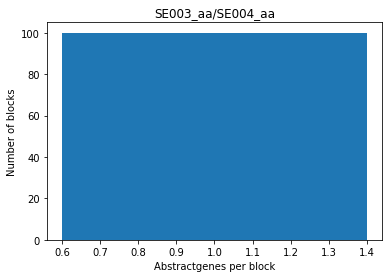

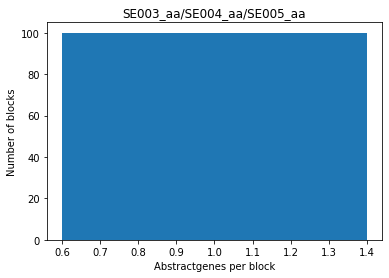

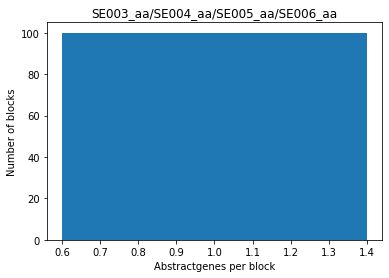

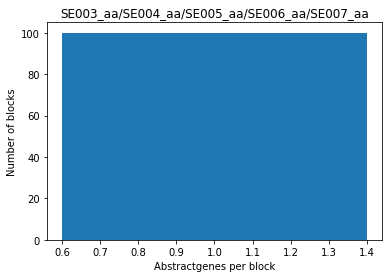

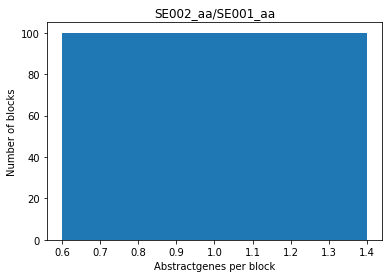

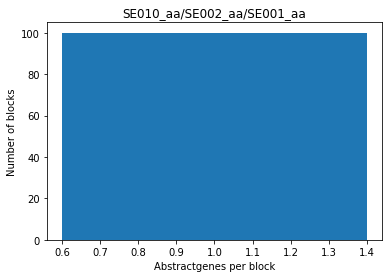

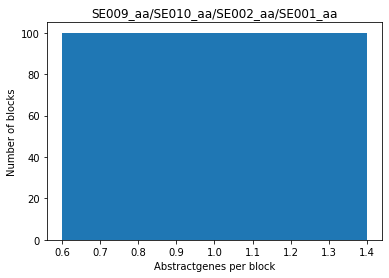

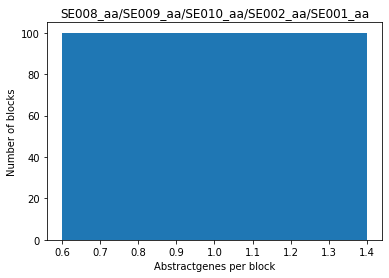

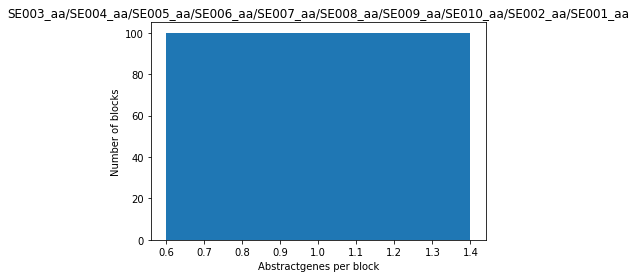

In [17]:
counter = 1
for node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
    assign_neighbors(node.genome)
    get_synteny_blocks(node.genome)
    assign_block_to_genes(node.genome)
    
    if isinstance(node.genome, pyham.AncestralGenome):
        joining_blocks(20, node.genome)
        
        ### Plot ###
        
        title = node.genome.name  
        raw_values = []
        
        for block in node.genome.new_synteny:
            count = 0
            
            for element in block:
                
                if isinstance(element, pyham.HOG):
                    count += 1
                    
            raw_values.append(count)
        
        label = list(set(raw_values))
        values = [0 for i in range(len(label))]
        
        for i in range(len(label)):
            
            for element in raw_values:
                
                if label[i] == element:
                    values[i] += 1

        plt.bar(label, values)
        plt.title(title)
        plt.xlabel('Abstractgenes per block')
        plt.ylabel('Number of blocks')
        plt.savefig('results/secondary_reconstruction_plot{}.png'.format(counter))
        counter += 1
        plt.show()

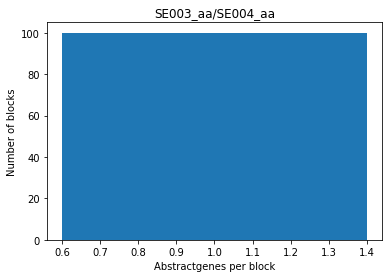

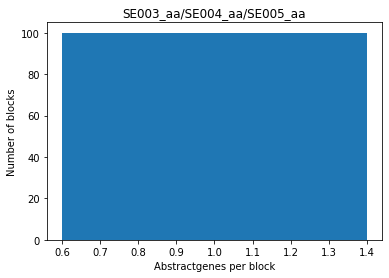

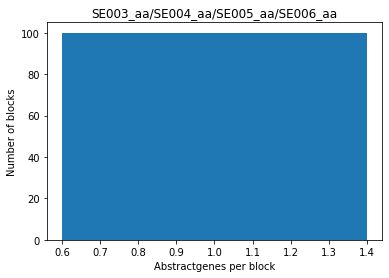

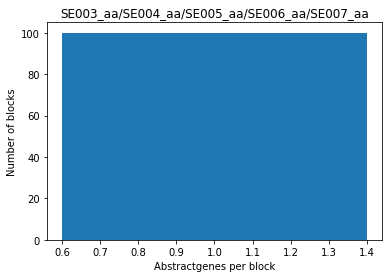

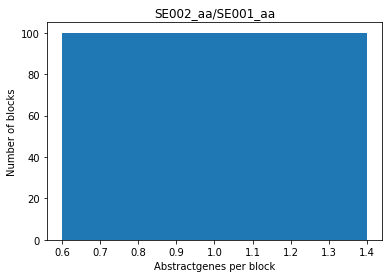

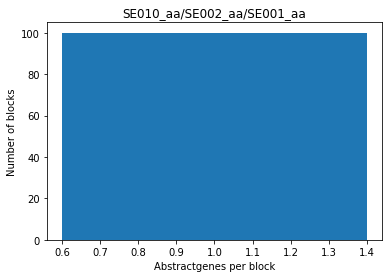

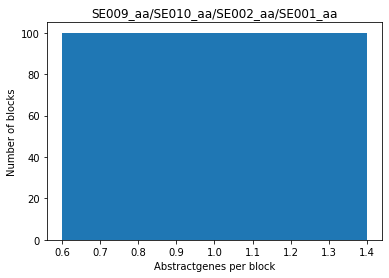

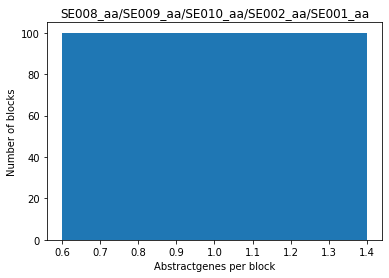

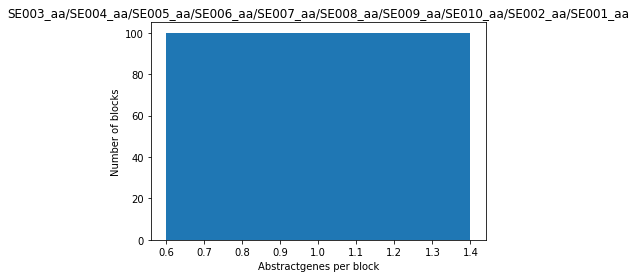

In [18]:
# Plots for the primary reconstruction

counter = 1
for node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
    
    if isinstance(node.genome, pyham.AncestralGenome):
        title = node.genome.name  
        raw_values = [len(block) for block in node.genome.synteny]  
        label = list(set(raw_values))
        values = [0 for i in range(len(label))]
        
        for i in range(len(label)):
            
            for element in raw_values:
                
                if label[i] == element:
                    values[i] += 1

        plt.bar(list(label), values)
        plt.title(title)
        plt.xlabel('Abstractgenes per block')
        plt.ylabel('Number of blocks')
        plt.savefig('results/primary_reconstruction_plot{}.png'.format(counter))
        counter += 1
        plt.show()

#

code below was alex showing me how dictionaries and keys work

#

In [19]:
x = {1: 'v 1',
     2: 'v 2'}

In [20]:
list(x)

[1, 2]

In [21]:
list(x.keys())

[1, 2]

In [139]:
list(x.values())

['v 1', 'v 2']

In [219]:
list(x.items())

[(1, 'v 1'), (2, 'v 2')]